In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import pandas as pd
data = pd.read_excel('AnapaSalesfin.xlsx')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   flight_id            193 non-null    int64         
 1   flight_no            193 non-null    object        
 2   departure_city       193 non-null    object        
 3   arrival_city         193 non-null    object        
 4   scheduled_departure  193 non-null    datetime64[ns]
 5   seats_sold           180 non-null    float64       
 6   economy_sold         180 non-null    float64       
 7   business_sold        180 non-null    float64       
 8   total_seats          193 non-null    int64         
 9   economy_value        180 non-null    float64       
 10  total_value          180 non-null    float64       
 11  model                193 non-null    object        
 12  flight_minutes       193 non-null    int64         
dtypes: datetime64[ns](1), float64(5), i

In [3]:
data[data['flight_id'] == 136678]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,total_value,model,flight_minutes
112,136678,PG0480,Anapa,Belgorod,2017-01-28 09:25:00,80.0,70.0,10.0,97,442200.0,631200.0,Sukhoi Superjet-100,50


In [4]:
# рейсы без данных по пассажирам и к-ве проданных мест - все из Анапы в Новокузнецк
data[data['economy_value'] == 0]

# уберем их полностью, так как они не подходят для анализа прибыльности
data = data[data['arrival_city'] != 'Novokuznetsk']

Добавим новые столбцы:

In [5]:
# день недели отправки рейса
data['departure_day'] = data['scheduled_departure'].dt.weekday
# время вылета
data['departure_time'] = data['scheduled_departure'].apply(lambda x: x.time())
# дата вылета
data['departure_date'] = data['scheduled_departure'].apply(lambda x: x.date())
# месяц вылета
data['departure_month'] = data['scheduled_departure'].dt.month

Из Анапы у нас летают два рейса в направлениях Анапа - Москва и Анапа-Белгород. За выбранный период было совершено по 90 перелетов в каждую сторону. При этом в Москву всегда летает Боинг, а в Белгород - Сухой. Рейс на Москву всегда отправляется в 10:05, а на Белгород  - в 9:25. В среднем, перелет в Москву длится 1 час и 40 минут, а в Белгород - 50 минут

In [6]:
# посмотрим, какие модели самолетов летают на рейсах из Анапы, куда и во сколько, а так же их среднюю длительность:
data.groupby(['flight_no', 'model', 'arrival_city', 'departure_time']).agg({'flight_id': ['count'],
                                                                            'flight_minutes': 'mean', 'total_seats': 'mean'})

,,,,flight_id,flight_minutes,total_seats
,,,,count,mean,mean
flight_no,model,arrival_city,departure_time,,,
PG0252,Boeing 737-300,Moscow,10:05:00,90,99.966667,130
PG0480,Sukhoi Superjet-100,Belgorod,09:25:00,90,50.011111,97


# Оценка прибыльности на основе дохода - расхода на топливо

In [7]:
# добавим расход топлива в литрах (на час) для каждой модели:
fuel_cons = {'Boeing 737-300': 2400,
             'Sukhoi Superjet-100': 1700}

# создадим новый признак расхода топлива для каждого рейса, исходя из длительности полета
# делим на 1150 для перевода в тонны (плотность топлива ниже плотности воды: в среднем в одной тонне топлива - 1150 литров)
data['used_fuel'] = data.apply(lambda row: fuel_cons[row['model']] / 60 * row['flight_minutes'] / 1150,
                               axis=1)

In [8]:
# добавим цены на топливо для декабря 2016 года и января-февраля 2017 (https://favt.gov.ru/):
fuel_prices = {12: 38867,
               1: 41435,
               2: 39553}

# теперь можем посчитать расходы на топливо по каждому рейсу
data['fuel_cost'] = data.apply(lambda row: round(fuel_prices[row['departure_month']]
                                                 * row['used_fuel'], 2), axis=1)

# выводим прибыль как разница между выручкой по билетам и расходом на топливо
data['revenue'] = data['total_value'] - data['fuel_cost']

Посмотрим на распределения: рейсы из Анапы в Москву более дорогостоящие в плане расхода на топливо (что ожидаемо исходя из длительности полета и бОльшего расхода Боинга), чем из Анапы в Белгород. 

<AxesSubplot:xlabel='fuel_cost', ylabel='Count'>

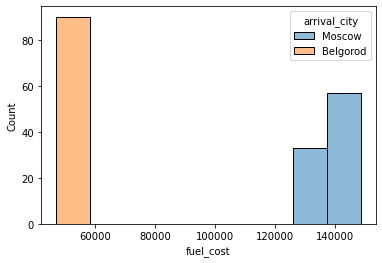

In [9]:
sns.histplot(data=data, x=data['fuel_cost'], hue=data['arrival_city'])

Также рейсы в Москву, в общем, имеют бОльшую выручку (как результат более высокой цены за билет и/или бОльшей заполненности самолета). На графике видны некоторые рейсы по каждому направлению, где выручка, ниже чем у остальных (около 25 рейсов в Белгород и некоторые 10 рейсов в Москву - будет интересно посмотреть на них отдельно)

<AxesSubplot:xlabel='total_value', ylabel='Count'>

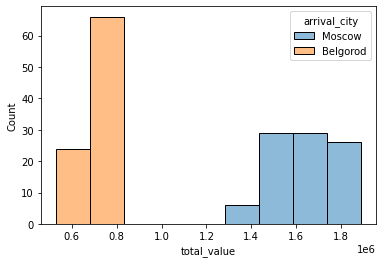

In [10]:
sns.histplot(data=data, x=data['total_value'], hue=data['arrival_city'])

Исходя из вышеописанного, ожидаемо, что и средяя прибыльность направления Анапа-Москва выше, чем Анапа-Белгород 

<function matplotlib.pyplot.show(close=None, block=None)>

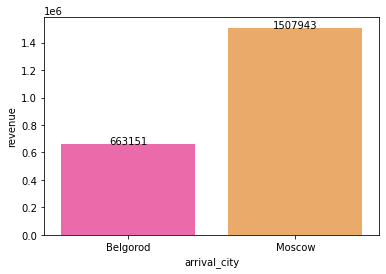

In [11]:
table = data.groupby('arrival_city').revenue.mean().reset_index()
gr = sns.barplot(x='arrival_city', y='revenue', data=table, palette='spring')


for index, row in table.iterrows():
    gr.text(row.name, row.revenue, round(
        row.revenue), color='black', ha="center")
plt.show

In [12]:
# таблица со средними значениями прибыльности по каждому направлению
means = data.groupby('arrival_city').revenue.mean()


def prof_check(row):
    # функция определяющая, если данный рейс имеет прибыльность ниже среднего по своему направлению
    if row['revenue'] < means[row['arrival_city']]:
        return 'below_average'
    else:
        return 'ok'


# создадим новый параметр на основе функции
data['profit_type'] = data.apply(lambda x: prof_check(x), axis=1)

In [13]:
# выведем параметр заполняемости рейса
data['seat_coverage'] = data['seats_sold']/data['total_seats']

Сравним заполненность рейсов с прибылью ниже среднего и с прибылью выше среднего для каждого из направлений.

Очевидно, что в случае обоих направлений, рейсы с прибылью ниже среднего имеют более низкую заполненность по сравнению с теми, у которых прибыльность в норме

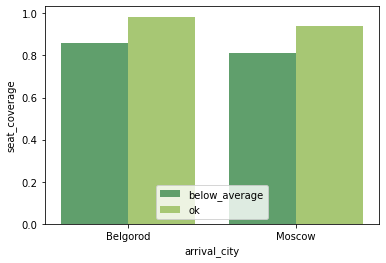

In [14]:
sc = data.groupby(['arrival_city', 'profit_type']
                  ).seat_coverage.mean().reset_index()
g = sns.barplot(x='arrival_city', y='seat_coverage',
                data=sc, hue='profit_type', palette='summer')
plt.legend(loc='lower center')

Посмотрим, если заполненность может быть обусловлена ценой (например, цены в этот день были выше - поэтому спрос оказался меньше). Для этого посчитаем средние значения цены по классу Эконом (так как они составляют 90% мест) и сравним для обоих направлений для двух типов рейсов

Видим, что цена здесь не является фактором:

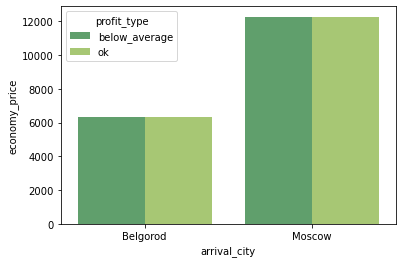

In [15]:
data['economy_price'] = data['economy_value'] / (data['economy_sold'])

prices_e = data.groupby(['arrival_city', 'profit_type'])[
    'economy_price'].mean().reset_index()
g = sns.barplot(x='arrival_city', y='economy_price',
                data=prices_e, hue='profit_type', palette='summer')

Посмотрим на зависимость заполняемости от дня недели:
для рейсов Анапа-Москва заметный спад к выходным, в то время как самая высокая заполняемость рейсов Анапа-Белгород наблюдается в среду

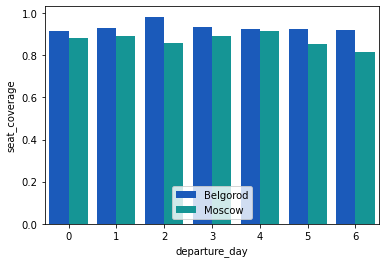

In [16]:
day_seats = data.groupby(['arrival_city', 'departure_day']
                         ).seat_coverage.mean().reset_index()
sns.barplot(x='departure_day', y='seat_coverage',
            data=day_seats, hue='arrival_city', palette='winter')
plt.legend(loc='lower center')

Посмотрим на заполненность рейсов с прибыльностью ниже среднего по дате

Для рейса Анапа-Белгород сильно выбиваются низкие значения заполненности (<70%) в дни 2017-01-30 и 2017-02-23. 
Примечательно то, что во время новогодних праздников, вопреки ожиданиям, заполненность рейсов не значительно ниже

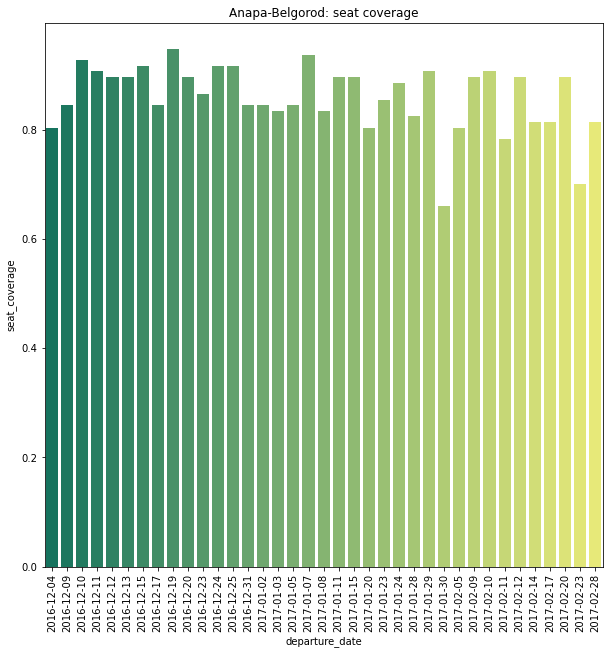

In [17]:
dates_t = data[data['profit_type'] == 'below_average'][['arrival_city', 'departure_date',
                                                        'seat_coverage']].sort_values(by=['arrival_city', 'departure_date'])
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x='departure_date', y='seat_coverage', ax=ax,
                data=dates_t[dates_t['arrival_city'] == 'Belgorod'], palette='summer')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Anapa-Belgorod: seat coverage')
plt.show()

В отличие от рейса Анапа-Белгород, данные по Анапа-Москва более равномерны без очевидных выбросов 

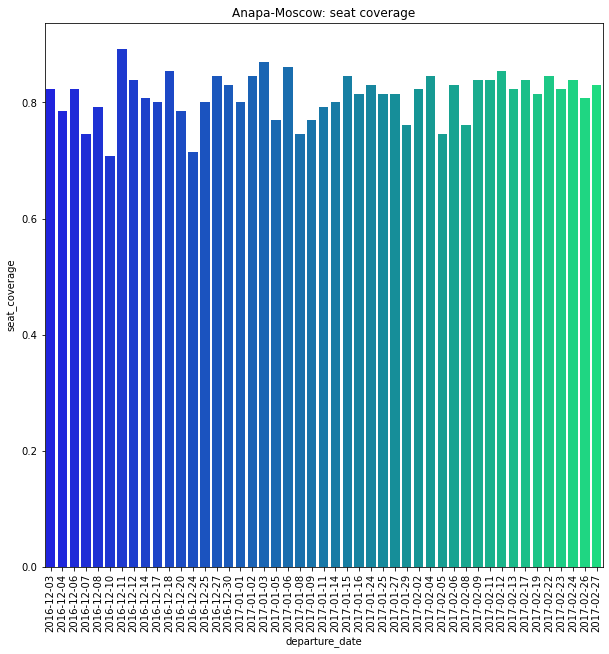

In [18]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g1 = sns.barplot(x='departure_date', y='seat_coverage', ax=ax,
                 data=dates_t[dates_t['arrival_city'] == 'Moscow'], palette='winter')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
g1.set_title('Anapa-Moscow: seat coverage')
plt.show()

Воспользуемся формулой межквартильного расстояния для определения выбросов исходя из прибыльности рейсов по двум направлениям 

In [19]:
def low_limit(dataset, city, column):
    # формула для определения нижней границы данных по формуле межквартильного расстояния
    q = np.quantile(dataset[dataset['arrival_city']
                            == city][column], [0.25, 0.75])
    IQR = q[1] - q[0]
    return q[0] - 1.5*IQR


# выводим рейсы на Белгород, прибыльность которых ниже определенного по формуле значения
data[(data['arrival_city'] == 'Belgorod') & (
    data['revenue'] < low_limit(data, 'Belgorod', 'revenue'))]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,...,departure_day,departure_time,departure_date,departure_month,used_fuel,fuel_cost,revenue,profit_type,seat_coverage,economy_price
102,136642,PG0480,Anapa,Belgorod,2017-01-30 09:25:00,64.0,54.0,10.0,97,342000.0,...,0,09:25:00,2017-01-30,1,1.207246,50022.25,480977.75,below_average,0.659794,6333.333333
144,136807,PG0480,Anapa,Belgorod,2017-02-23 09:25:00,68.0,60.0,8.0,97,379800.0,...,3,09:25:00,2017-02-23,2,1.231884,48724.71,482275.29,below_average,0.701031,6330.000000


In [20]:
# выбросов с точки зрения прибыльности среди рейсов Анапа-Москва обнаружено не было
data[(data['arrival_city'] == 'Moscow') & (
    data['revenue'] < low_limit(data, 'Moscow', 'revenue'))]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,...,departure_day,departure_time,departure_date,departure_month,used_fuel,fuel_cost,revenue,profit_type,seat_coverage,economy_price


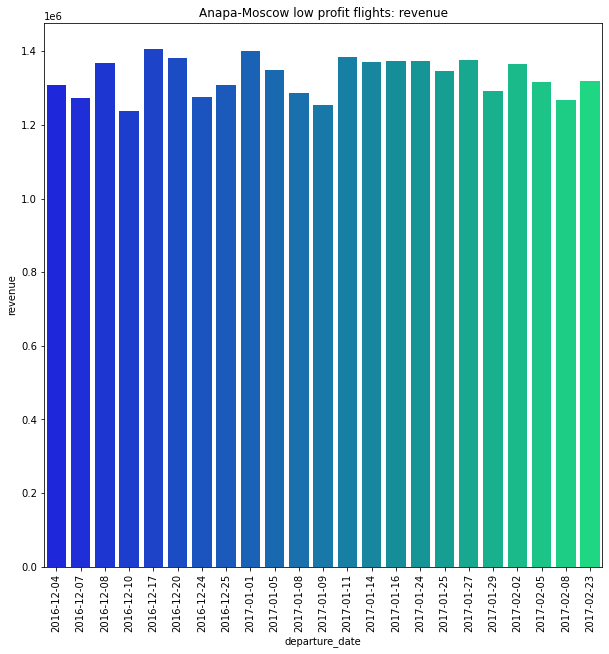

In [21]:
# посмотрим на рейсы, прибыльность которых находится в первом квартиле
filt_m = data[(data['arrival_city'] == 'Moscow')
              & (data['revenue'] < np.quantile(data[data['arrival_city']
                                                    == 'Moscow']['revenue'], 0.25))].sort_values(by='departure_date')

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g1 = sns.barplot(x='departure_date', y='revenue', ax=ax,
                 data=filt_m, palette='winter')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
g1.set_title('Anapa-Moscow low profit flights: revenue')
plt.show()

На графике заметно, что среди всех самых низкоприбыльных рейсов Анапа-Москва, худшие из них случаются именно в декабре. 
Посмотрим на декабрьские рейсы из Анапы в Москву более детально, распределив по дням недели и сравним данное распределение с рейсами января

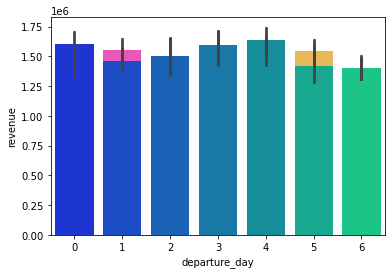

In [22]:
dec = data[(data['departure_month'] == 12) & (data['arrival_city'] == 'Moscow')][['departure_day', 'revenue']]
jan = data[(data['departure_month'] == 1) & (data['arrival_city'] == 'Moscow')][['departure_day', 'revenue']]
sns.barplot(x='departure_day', y='revenue', data=jan, palette='spring')
sns.barplot(x='departure_day', y='revenue', data=dec, palette='winter')
plt.show()

Действительно, как было замечено ранее, прибыльность рейсов выходных дней ниже, чем будних. 
Кроме этого, на графике заметно, что прибыльность субботних декабрських рейсов (зеленый цвет) Анапа-Москва горазде ниже, чем в январе (желтый).
Следовательно, их можно пересмотреть:


In [23]:
# выводим данные по декабрьским субботним рейсам:
data[(data['departure_month'] == 12) & (
    data['arrival_city'] == 'Moscow') & (data['departure_day'] == 5)]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,...,departure_day,departure_time,departure_date,departure_month,used_fuel,fuel_cost,revenue,profit_type,seat_coverage,economy_price
30,136253,PG0252,Anapa,Moscow,2016-12-24 10:05:00,93.0,82.0,11.0,130,1005200.0,...,5,10:05:00,2016-12-24,12,3.408696,132485.77,1275314.23,below_average,0.715385,12258.536585
47,136318,PG0252,Anapa,Moscow,2016-12-17 10:05:00,104.0,93.0,11.0,130,1141800.0,...,5,10:05:00,2016-12-17,12,3.547826,137893.36,1406506.64,below_average,0.800000,12277.419355
56,136352,PG0252,Anapa,Moscow,2016-12-10 10:05:00,92.0,82.0,10.0,130,1006400.0,...,5,10:05:00,2016-12-10,12,3.478261,135189.57,1237210.43,below_average,0.707692,12273.170732
59,136368,PG0252,Anapa,Moscow,2016-12-31 10:05:00,130.0,118.0,12.0,130,1446800.0,...,5,10:05:00,2016-12-31,12,3.478261,135189.57,1750810.43,ok,1.000000,12261.016949
65,136391,PG0252,Anapa,Moscow,2016-12-03 10:05:00,107.0,97.0,10.0,130,1190600.0,...,5,10:05:00,2016-12-03,12,3.478261,135189.57,1421410.43,below_average,0.823077,12274.226804


Один из таких рейсов выпадает на 31-12-2016 и, как показывают данные, является очень даже прибыльным с полной посадкой, поэтому мы исключим его из выборки

In [24]:
data[(data['departure_month'] == 12) & (data['arrival_city'] == 'Moscow') & (data['departure_day'] == 5)
     & (data['departure_date'] != '2016-12-31')]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,...,departure_day,departure_time,departure_date,departure_month,used_fuel,fuel_cost,revenue,profit_type,seat_coverage,economy_price
30,136253,PG0252,Anapa,Moscow,2016-12-24 10:05:00,93.0,82.0,11.0,130,1005200.0,...,5,10:05:00,2016-12-24,12,3.408696,132485.77,1275314.23,below_average,0.715385,12258.536585
47,136318,PG0252,Anapa,Moscow,2016-12-17 10:05:00,104.0,93.0,11.0,130,1141800.0,...,5,10:05:00,2016-12-17,12,3.547826,137893.36,1406506.64,below_average,0.800000,12277.419355
56,136352,PG0252,Anapa,Moscow,2016-12-10 10:05:00,92.0,82.0,10.0,130,1006400.0,...,5,10:05:00,2016-12-10,12,3.478261,135189.57,1237210.43,below_average,0.707692,12273.170732
59,136368,PG0252,Anapa,Moscow,2016-12-31 10:05:00,130.0,118.0,12.0,130,1446800.0,...,5,10:05:00,2016-12-31,12,3.478261,135189.57,1750810.43,ok,1.000000,12261.016949
65,136391,PG0252,Anapa,Moscow,2016-12-03 10:05:00,107.0,97.0,10.0,130,1190600.0,...,5,10:05:00,2016-12-03,12,3.478261,135189.57,1421410.43,below_average,0.823077,12274.226804


Следующие 6 перелетов (2 в Белгород и 4 в Москву) были определены как самые низкоприбыльные и могут быть отменены в будущем:

In [25]:
ids_to_cancel = [136642, 136807, 136253, 136318, 136352,  136391]

data.loc[data.apply(lambda x: x['flight_id'] in ids_to_cancel, axis=1)]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure,seats_sold,economy_sold,business_sold,total_seats,economy_value,...,departure_day,departure_time,departure_date,departure_month,used_fuel,fuel_cost,revenue,profit_type,seat_coverage,economy_price
30,136253,PG0252,Anapa,Moscow,2016-12-24 10:05:00,93.0,82.0,11.0,130,1005200.0,...,5,10:05:00,2016-12-24,12,3.408696,132485.77,1275314.23,below_average,0.715385,12258.536585
47,136318,PG0252,Anapa,Moscow,2016-12-17 10:05:00,104.0,93.0,11.0,130,1141800.0,...,5,10:05:00,2016-12-17,12,3.547826,137893.36,1406506.64,below_average,0.800000,12277.419355
56,136352,PG0252,Anapa,Moscow,2016-12-10 10:05:00,92.0,82.0,10.0,130,1006400.0,...,5,10:05:00,2016-12-10,12,3.478261,135189.57,1237210.43,below_average,0.707692,12273.170732
65,136391,PG0252,Anapa,Moscow,2016-12-03 10:05:00,107.0,97.0,10.0,130,1190600.0,...,5,10:05:00,2016-12-03,12,3.478261,135189.57,1421410.43,below_average,0.823077,12274.226804
102,136642,PG0480,Anapa,Belgorod,2017-01-30 09:25:00,64.0,54.0,10.0,97,342000.0,...,0,09:25:00,2017-01-30,1,1.207246,50022.25,480977.75,below_average,0.659794,6333.333333
144,136807,PG0480,Anapa,Belgorod,2017-02-23 09:25:00,68.0,60.0,8.0,97,379800.0,...,3,09:25:00,2017-02-23,2,1.231884,48724.71,482275.29,below_average,0.701031,6330.000000
